# 0.8 Hierarchical Learning

Quickly put together a model to see how neural networks perform when run on tasks with a heirarchical structure such as the one laid out in [this](http://ski.clps.brown.edu/papers/CollinsFrank_Cognition.pdf) paper.

## Boilerplate

The following subsections are largely boilerplate code, so skip around as needed.

### Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,matplotlib,seaborn,tensorflow

Thu Jun 06 2019 16:35:02 

CPython 3.6.8
IPython 7.3.0

numpy 1.16.2
matplotlib 3.0.2
seaborn 0.9.0
tensorflow 1.10.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.18.0-20-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 0acecbc0d8d21d0b2ddae2d03e5b9a2ba46c9778
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode.
%matplotlib inline

### Imports

Static imports that shouldn't necessarily change throughout the notebook.

In [4]:
# Standard library imports
import logging
import os
from pathlib import Path
from copy import deepcopy
from pprint import pprint

# Third party
import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pstar import pdict

Local imports that may or may not be autoreloaded. This section contains things that will likely have to be re-imported multiple times, and have additions or subtractions made throughout the project.

In [5]:
# Utility functions
%aimport leabratf.utils
from leabratf.utils import setup_logging
%aimport leabratf.constants
from leabratf.constants import DIR_DATA_PROC

### Initial Setup

Set [seaborn defaults](https://seaborn.pydata.org/generated/seaborn.set.html) for matplotlib.

In [6]:
sns.set()
sns.set_context("notebook")

Set up the logger configuration to something more useful than baseline. Creates log files for the different log levels in the `logs` directory.

See `logging.yml` for the exact logging configuration.

In [7]:
# Run base logger setup
setup_logging()
# Define a logger object
logger = logging.getLogger('leabratf')

## Task Definitions

### Constants

In [8]:
N_COLORS = 5
N_SHAPES = 4
N_ACTIONS = 4

### Phase Colors and Shapes

In [9]:
# All the colors and shapes
all_colors = [0, 1, 2, 3, 4]
all_shapes = [1 ,2, 3, 4]

# Phase A
phase_a_colors = [0, 1, 2]
phase_a_shapes = [1, 2]

# Phase B
phase_b_colors = [0, 1, 2]
phase_b_shapes = [3, 4]

# Phase C
phase_c_colors = [3, 4]
phase_c_shapes = [3, 4]

# Color lines correspond to a particular horizontal line
# # colors are not uniformly selected for
# Shapes corespond to a particular vertical line
# Color, Shape combinations correspond to a particular action 1-4

### Action Mapping


In [10]:
action_dictonary = {
    # (Color,Shape) : Action
    #      Phase A       |       Phase B
    (0,1) : 1, (0,2) : 2, (0,3) : 1, (0,4) : 3, # TS 1
    (1,1) : 1, (1,2) : 2, (1,3) : 1, (1,4) : 3, # TS 1
    (2,1) : 3, (2,2) : 4, (2,3) : 4, (2,4) : 2, # TS 2
    #                    |       Phase C
                          (3,3) : 1, (3,4) : 3, # TS Old
                          (4,3) : 1, (4,4) : 2} # TS New

## Data Generation Functions

### Phase

In [58]:
def phase_labels(n_samples,
                 phase_colors,
                 phase_shapes,
                 p_colors,
                 p_shapes,
                 n_colors=N_COLORS,
                 n_shapes=N_SHAPES,
                ):
    """Base label generator."""
    # N Color samples
    color_choices = np.eye(n_colors)[np.random.choice(
        phase_colors,
        size=n_samples,
        replace=True,
        p=p_colors,
    )].reshape((n_samples, n_colors, 1))
    # N Shape samples
    shape_choices = np.eye(n_shapes)[np.random.choice(
        [s-1 for s in phase_shapes],
        size=n_samples,
        replace=True,
        p=p_shapes,
    )].reshape((n_samples, n_shapes, 1))
    # Return the choices
    return color_choices, shape_choices    

def phase_a_labels(n_samples=120, 
                   colors=phase_a_colors,
                   shapes=phase_a_shapes,
                   p_colors=None,
                   p_shapes=None,
                ):
    """Label generator with defaults for phase a"""
    # Color and shape probabilities
    p_colors = p_colors or [.25, .25, .5]
    p_shapes = p_shapes or [.5, .5]
    return phase_labels(n_samples, colors, shapes, 
                        p_colors, p_shapes)

def phase_b_labels(n_samples=120, 
                   colors=phase_b_colors,
                   shapes=phase_b_shapes,
                   p_colors=None,
                   p_shapes=None,
                ):
    """Label generator with defaults for phase b"""
    # Color and shape probabilities
    p_colors = p_colors or [.25, .25, .5]
    p_shapes = p_shapes or [.5, .5]
    return phase_labels(n_samples, colors, shapes, 
                        p_colors, p_shapes)

def phase_c_labels(n_samples=120, 
                   colors=phase_c_colors,
                   shapes=phase_c_shapes,
                   p_colors=None,
                   p_shapes=None,
                ):
    """Label generator with defaults for phase c"""
    # Color and shape probabilities
    p_colors = p_colors or [.5, .5]
    p_shapes = p_shapes or [.5, .5]
    return phase_labels(n_samples, colors, shapes, 
                        p_colors, p_shapes)

phase_labels_funcs = pdict({
    'a' : phase_a_labels,
    'b' : phase_b_labels,
    'c' : phase_c_labels
}) 

### Helper Functions

In [59]:
def integer_labels(labels):
    """Turns one-hot labels to integers"""
    return [np.where(r==1)[0][0] for r in labels]
    
def input_array(color_choices, shape_choices, 
                n_shapes=N_SHAPES, n_colors=N_COLORS):
    """Turns one-hot labels to 2D input arrays with lines"""
    # Full Color array
    color_array = np.tile(color_choices, n_shapes)
    # Full Shape Array
    shape_array = np.transpose(
        np.tile(shape_choices, n_colors),
        [0, 2, 1])
        
    # Full data with both
    x_data = np.maximum(color_array, shape_array)
    return x_data

### Action Selection

In [60]:
def actions(color_choices, shape_choices, action_dict=None, n_actions=N_ACTIONS):
    """Implements the mapping from shapes and colors to actions"""
    # Create the action dictionary to compare to
    action_dict = action_dict or action_dictonary
    # Make binary from one hot and increment shape by 1
    color_binarized = integer_labels(color_choices)
    shape_binarized = [i+1 for i in integer_labels(shape_choices)]
    # Compile into a list of tuples
    label_tuples = [(color, shape) for color, shape in zip(
        color_binarized, shape_binarized)]
    # Substitute based on the action dictionary
    integer_actions = [action_dict[key] for key in label_tuples]
    return np.eye(n_actions)[np.array(integer_actions)-1]

## Making the Datasets

### Generating the Phase Data

In [61]:
datasets = [pdict(), pdict()]
for key in phase_labels_funcs.keys():
    for dataset in datasets:
        choices = phase_labels_funcs[key]()
        inputs = input_array(*choices)
        labels = actions(*choices)
        dataset[key] = (inputs, labels)
train_dataset, test_dataset = datasets

### Tensorflow Datasets

In [62]:
def make_tf_datasets(datasets, init_ops=None):
    # The first step of the setup is that each of the datasets (training, validation, and 
    # testing) are turned into their own `Dataset` objects.
    tf_datasets = pdict()
    for data, name in zip(datasets, ['train', 'test']):
        for key in data.keys():
            tf_datasets[f'{name}_{key}'] = tf.data.Dataset.from_tensor_slices(
                data[key]).repeat().batch(1 if name=='train' 
                                          else len(data[key][0]))
    
    # Next, let's define the iterators for each of the datasets, and then add their 
    # initializations to the `init_ops` list.
    # Training iterator
    iterators = pdict({name : data.make_initializable_iterator()
                      for name, data in tf_datasets.items()})

    # Add the initiatlizations to the init opts
    init_ops = init_ops or []
    init_ops += [iter.initializer for iter in iterators.values()]
    
    first_dataset = list(tf_datasets.values())[0] 
    output_types, output_shapes = first_dataset.output_types, first_dataset.output_shapes
    
    # And finally, the interesting part. Rather than creating separate next elements for 
    # the model, the `tf.data` API has a string handler iterator so we can contextually 
    # switch the active `Dataset` object, resulting in different values being used for `x` 
    # and `y`.

    # The way this is done is by defining a `tf.placeholder` variable, which is used 
    # first to create a string handler iterator, and later to hold the dataset-indicating 
    # string handle. The string handler iterator is what then changes the values of `x` and 
    # `y`, naturally also supplying them using the `get_next` method.
    # The placeholder variable of type string
    handle = tf.placeholder(tf.string, shape=[])
    
    # Iterator from string handle
    handle_iterator = tf.data.Iterator.from_string_handle(
        handle, output_types, output_shapes)

    # x and y that will be used in the graph
    x, y = handle_iterator.get_next()
    
    return x, y, iterators, handle, init_ops

## Graph Definitions

### TF Variables

Straight forward section where we define the weights and biases. One thing to note is that the weights are initialized using the `tf.contrib.layers.xavier_initializer`. 

Additionally, create an empty list that will contain the initialization operations to be performed at the start of a session.

In [63]:
N_INPUTS = N_COLORS * N_SHAPES
N_HIDDEN_1 = 100 
N_OUTPUTS = 4

# Cleanup any residual nodes
tf.reset_default_graph()
init_ops = []

# Weights and biases
weights = pdict({
    'h1': tf.get_variable(
        name='w_h1', 
        shape=[N_INPUTS, N_HIDDEN_1],
        initializer=tf.contrib.layers.xavier_initializer(),
        dtype=tf.float64),
    'out': tf.get_variable(
        name='w_out', 
        shape=[N_HIDDEN_1, N_OUTPUTS],
        initializer=tf.contrib.layers.xavier_initializer(),
        dtype=tf.float64),
})
biases = pdict({
    'b1': tf.get_variable(
        name="b_1", 
        shape=[N_HIDDEN_1], 
        initializer=tf.zeros_initializer(),
        dtype=tf.float64),
    'out': tf.get_variable(
        name="b_out", 
        shape=[N_OUTPUTS], 
        initializer=tf.zeros_initializer(),
        dtype=tf.float64),
})

init_ops = []

### Model and Metrics

The architecture is the same as previous notebooks. See `nb-0.3` for more details.

In [64]:
def oreilly_model(inputs):
    # Reshape for hidden layer
    inputs = tf.reshape(inputs, shape=[-1, N_INPUTS])
    # Single hidden layer
    inputs = tf.sigmoid(tf.add(tf.matmul(inputs, weights['h1']), biases['b1']))
    # Output layer
    inputs = tf.add(tf.matmul(inputs, weights['out']), biases['out'])
    # Reshape for labels
    return tf.reshape(inputs, shape=[-1, N_OUTPUTS])

In [65]:
TF_DEVICE = '/device:CPU:0'
with tf.device(TF_DEVICE):
    # Get the relevant dataset nodes
    x, y, iterators, handler, init_ops = make_tf_datasets(
        datasets, init_ops)

    # Build the model
    logits = oreilly_model(x)
    # Ensure y is cast to the same type as logits
    labels = tf.cast(y, logits.dtype)
    
    # We will keep this in for now
    # Define alpha as placeholder variable
    alpha_ph = tf.placeholder(tf.float32, shape=[])

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.losses.softmax_cross_entropy(
        labels, logits))

    # Define some intermediate nodes
    predictions = tf.nn.softmax(logits)
    rounded_predictions = tf.round(predictions)
    equal_labels_and_preds = tf.equal(rounded_predictions, labels)
    
    # Accuracy 
    sample_acc = tf.reduce_all(equal_labels_and_preds, axis=1)
    accuracy = tf.reduce_mean(tf.cast(sample_acc, tf.float64))
 
#     # Elemental Accuracy 
#     el_acc_op = tf.reduce_mean(tf.cast(equal_labels_and_preds, tf.float32))
#     # Axis Accuracy
#     axis_acc_op = tf.reduce_mean(tf.cast(axis_acc, tf.float32))
#     # Slot Accuracy
#     slot_acc_op = tf.reduce_mean(tf.cast(slot_acc, tf.float32))
#     # Sample Accuracy
#     sample_acc_op = tf.reduce_mean(tf.cast(sample_acc, tf.float32))
    
#     # metric ops
#     met_op_names = ['loss', 'el_acc', 'ax_acc', 'sl_acc', 'sm_acc']
#     met_ops = [loss_op, el_acc_op, axis_acc_op, slot_acc_op, sample_acc_op]
#     # Put them in a dict
#     met_op_dict = pdict({name : op for name, op in zip(met_op_names, met_ops)})

#     # Generic metrics dict
#     generic_metrics_dict = lambda : pdict({name : [] 
#                                            for name in met_op_names+['epoch']})

In [66]:
phase = 'a'
def test_func(init_ops):
    with tf.Session() as sess:
        if tf.global_variables_initializer() not in init_ops:
            init_ops += [tf.global_variables_initializer(), 
                         tf.local_variables_initializer()]
        sess.run(init_ops)
        handles = pdict({name : sess.run(iterators[name].string_handle())
                    for name in iterators.keys()})
        return sess.run(accuracy, feed_dict={handler: handles[f'test_{phase}']})
test_func(init_ops)

0.23333333333333334


### Varying the Optimizer

Let's create several different training operations.

In [67]:
with tf.device(TF_DEVICE):
    # Adam
    train_op_adam = tf.train.AdamOptimizer(alpha_ph).minimize(loss_op)
    # Adadelta 
    train_op_adadelta = tf.train.AdadeltaOptimizer(alpha_ph).minimize(loss_op)
    # RMSProp
    train_op_rmsprop = tf.train.RMSPropOptimizer(alpha_ph).minimize(loss_op)
    # SGD
    train_op_sgd = tf.train.GradientDescentOptimizer(alpha_ph).minimize(loss_op)
    
# And now add these to a dictionary
optimizer_dict = pdict({
    'Adam' : train_op_adam,
    'Adadelta' : train_op_adadelta,
    'RMSProp' : train_op_rmsprop,
    'sgd' : train_op_sgd,
})

### New Session Function

In the event that we do not want to immediately close sessions, we won't be using the context handler but will still need to grab new sessions as necessary. So let's quickly write a function that will properly run `sess.close()` if a previous session exists and then return a new `tf.Session` instance.

In [68]:
def new_session(*args, **kwargs):
    # Try to close the globally defined session if it isn't already
    try:
        if not sess._closed:
            sess.close()
    # If it doesn't exist, then just pass
    except NameError:
        pass
    # Return the new instance
    return tf.Session(*args, **kwargs)

### Defining the Training Function

Let's define a function that runs the training routine and accepts the number of epochs as the inputs.

In [69]:
# Based on code from 
# https://codereview.stackexchange.com/questions/169870/decorator-to-measure-execution-time-of-a-function
from functools import wraps
from time import time
import datetime

def timing(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time()
        result = func(*args, **kwargs)
        end = time()
        logger.info('Elapsed time: {}'.format(
            datetime.timedelta(seconds=end-start)))
        return result
    return wrapper

In [70]:
@timing
def train_exp(
    sess, 
    lr=0.0033, 
    epochs=100,
    train_op=optimizer_dict['Adam'], 
    init_ops=None,
    verbose=False,
    phases=['a'],
    n_train=None,
    n_val=5,
):
    log_level = logger.info if verbose else logger.debug
    log_level(f'Beginning training using learning rate {lr}, {train_op.name} '
              f'training routine, for {epochs} epochs')
    # Ensure this is an int
    epochs = int(epochs)
    # Dict with the various metrics we care about while training
    phase_metrics = pdict()
    
    # Run the initialization ops
    init_ops = init_ops or []
    if tf.global_variables_initializer() not in init_ops:
        init_ops += [tf.global_variables_initializer(), 
                     tf.local_variables_initializer()]
    sess.run(init_ops)
    
    # Define training and validation handlers
    handles = pdict({name : sess.run(iterators[name].string_handle())
                    for name in iterators.keys()})
    
    for phase in phases:
        n_train = len(train_dataset[phase][0])
        training_metrics = pdict({'loss':[], 'accuracy':[], 'sample':[]})
        for epoch in range(epochs):
            for i in range(n_train):
                # Training op and compute metrics
                _ = sess.run(
                    train_op, 
                    feed_dict={alpha_ph: lr, handler: handles[f'train_{phase}']})

                if not i % n_val or i == n_train - 1:
                    metrics = sess.run(
                        [loss_op, accuracy],
                        feed_dict={handler: handles[f'test_{phase}']})
                    # Record
                    for key, metric in zip(['loss', 'accuracy'], metrics):
                        training_metrics[key].append(metric)
                    training_metrics['sample'].append(i + epoch*n_train)
                    log_level(f'Completed Sample {i + epoch*n_train}')
        phase_metrics[phase] = training_metrics

    return phase_metrics

## Training and Testing on the Phase Data

2019-06-06 16:52:04 apra-xps-13 leabratf[22508] INFO Elapsed time: 0:00:00.995685


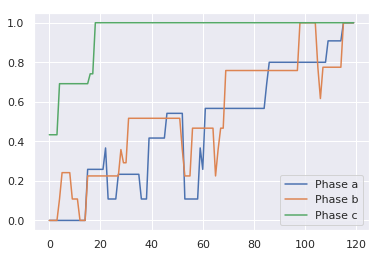

In [73]:
sess = new_session()
phase_metrics = train_exp(
    sess, 
    lr=0.00333, 
    epochs=1,
    train_op=optimizer_dict['Adam'], 
    init_ops=init_ops,
    verbose=False,
    phases=['a', 'b', 'c'],
    n_train=None,
    n_val=1,
)
for phase, data in phase_metrics.items():
    plt.plot(data.sample, data['accuracy'], label=f'Phase {phase}')
plt.legend()
plt.show()

### Plots for Multiple Models

In [84]:
%%time
N_MODELS = 50
all_phase_metrics = [train_exp(
    sess, 
    lr=0.00333, 
    epochs=1,
    train_op=optimizer_dict['Adam'], 
    init_ops=init_ops,
    verbose=False,
    phases=['a', 'b', 'c'],
    n_train=None,
    n_val=1,
) for _ in range(N_MODELS)]

2019-06-06 17:15:20 apra-xps-13 leabratf[22508] INFO Elapsed time: 0:00:01.041440
2019-06-06 17:15:21 apra-xps-13 leabratf[22508] INFO Elapsed time: 0:00:01.228136
2019-06-06 17:15:23 apra-xps-13 leabratf[22508] INFO Elapsed time: 0:00:01.943069
2019-06-06 17:15:24 apra-xps-13 leabratf[22508] INFO Elapsed time: 0:00:01.460180
2019-06-06 17:15:26 apra-xps-13 leabratf[22508] INFO Elapsed time: 0:00:01.710909
2019-06-06 17:15:28 apra-xps-13 leabratf[22508] INFO Elapsed time: 0:00:01.786138
2019-06-06 17:15:29 apra-xps-13 leabratf[22508] INFO Elapsed time: 0:00:00.877848
2019-06-06 17:15:30 apra-xps-13 leabratf[22508] INFO Elapsed time: 0:00:00.969888
2019-06-06 17:15:30 apra-xps-13 leabratf[22508] INFO Elapsed time: 0:00:00.847245
2019-06-06 17:15:31 apra-xps-13 leabratf[22508] INFO Elapsed time: 0:00:00.755489
2019-06-06 17:15:32 apra-xps-13 leabratf[22508] INFO Elapsed time: 0:00:00.825465
2019-06-06 17:15:33 apra-xps-13 leabratf[22508] INFO Elapsed time: 0:00:00.846412
2019-06-06 17:15

CPU times: user 1min 15s, sys: 6.89 s, total: 1min 22s
Wall time: 55.1 s


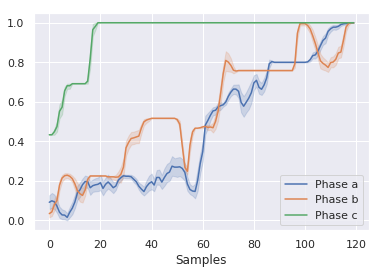

In [85]:
model_average = True
# Empty lists for the long form data
long_samples, long_metrics, long_hues, long_units = [], [], [], []

# Loop through each model's data
for i, model_metrics in enumerate(all_phase_metrics):
    # Plot the number of epochs according to the data with the shortest
    # number of epochs.
    # Add to the long form lists
    for key in model_metrics.keys():
        n_samples = len(model_metrics['a']['sample'])
        label = key
        units = i
        long_samples += model_metrics[key]['sample']
        long_metrics += model_metrics[key]['accuracy']
        long_hues += [f'Phase {label}']*n_samples
        long_units += [units]*n_samples

if model_average:
    sns.lineplot(x=long_samples, y=long_metrics, hue=long_hues, 
                 estimator='mean')
# Plot each line individually
else:
    sns.lineplot(x=long_samples, y=long_metrics, hue=long_hues, 
                 estimator=None, units=long_units)

# Title, axis, and 500 epoch line
plt.xlabel('Samples')
plt.show()